In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("szrlee/stock-time-series-20050101-to-20171231")

print("Path to dataset files:", path)

Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/szrlee/stock-time-series-20050101-to-20171231/versions/3


In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

2024-12-09 21:20:45.295135: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 21:20:45.321135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 21:20:45.321156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 21:20:45.321812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 21:20:45.326328: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Some functions to help out with
def plot_predictions(test, predicted):
    plt.figure(figsize=(12, 4))
    plt.plot(test, color="red", label="Real IBM Stock Price")
    plt.plot(predicted, color="blue", label="Predicted IBM Stock Price")
    plt.title("IBM Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("IBM Stock Price")
    plt.legend()
    plt.show()


def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    df_dict = {"mae": mae, "mse": mse, "rmse": rmse}

    df = pd.DataFrame([df_dict])
    return df

In [4]:
# First, we get the data
dataset = pd.read_csv(
    "/home/ubuntu/.cache/kagglehub/datasets/szrlee/stock-time-series-20050101-to-20171231/versions/3/IBM_2006-01-01_to_2018-01-01.csv",
    index_col="Date",
    parse_dates=["Date"],
)
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [5]:
# Select All Values from first Column
training_set = dataset[:"2016"].iloc[:, 1:2]
test_set = dataset["2017":].iloc[:, 1:2]

In [6]:
training_set.head()

,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90
2006-01-06,85.03
2006-01-09,84.25


In [7]:
test_set.head()

,High
Date,
2017-01-03,167.87
2017-01-04,169.87
2017-01-05,169.39
2017-01-06,169.92
2017-01-09,169.80


In [8]:
# Select only Values from Sets without Index
training_set = dataset[:"2016"].iloc[:, 1:2].values
test_set = dataset["2017":].iloc[:, 1:2].values

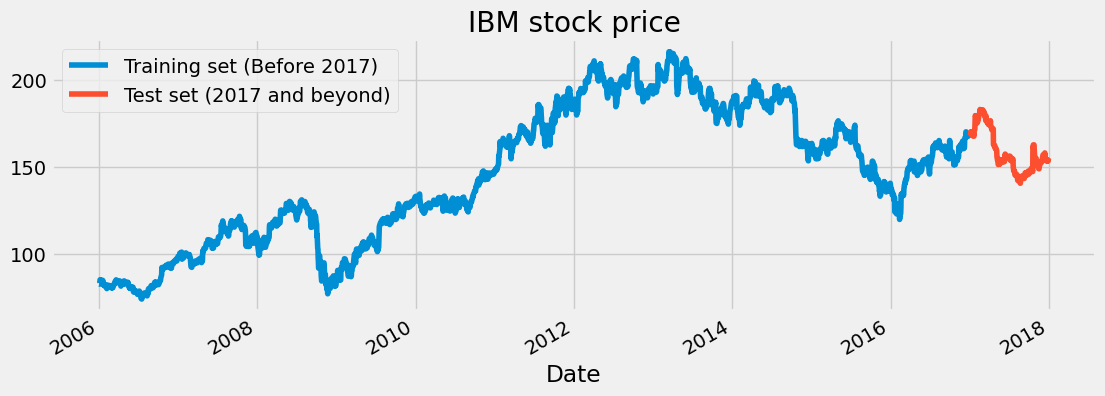

In [9]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:"2016"].plot(figsize=(12, 4), legend=True)
dataset["High"]["2017":].plot(figsize=(12, 4), legend=True)
plt.legend(["Training set (Before 2017)", "Test set (2017 and beyond)"])
plt.title("IBM stock price")
plt.show()

In [10]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [11]:
# Save Scaler
with open("scaler.pickle", "wb") as f:
    pickle.dump(sc, f)

In [12]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - 60 : i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(2709, 60)

In [14]:
# Reshaping to the shape (2709, 60, 1) is necessary because:
# 1. LSTMs expect 3D inputs (samples, timesteps, features).
# 2. It helps the model to process the temporal dependencies in the data correctly.
# 3. Your data is only 2D so far, and the third dimension (features) must be added explicitly.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
X_train.shape

(2709, 60, 1)

In [16]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer (no activation because regression analysis)
model.add(Dense(units=1))

2024-12-09 21:20:46.488793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 21:20:46.513833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 21:20:46.513965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
# define training callbacks

early_stopping = callbacks.EarlyStopping(
    patience=12, monitor="loss", restore_best_weights=True
)

reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(
    patience=6, monitor="loss", verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath="./models", monitor="loss", save_best_only=True
)

callbacks = [early_stopping, reduce_lr_on_plateau, model_checkpoint]

In [18]:
optimizer = Adam()

# Compiling the RNN
model.compile(optimizer=optimizer, loss="mean_squared_error")
# Fitting to the training set
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100


2024-12-09 21:20:50.014924: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-09 21:20:50.687705: I external/local_xla/xla/service/service.cc:168] XLA service 0x76674c36ede0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 21:20:50.687721: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-12-09 21:20:50.691308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733775650.736790  140619 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/85 [===========================>..] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 10s 79ms/step - loss: 0.0203 - lr: 0.0010
Epoch 2/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0053INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0052 - lr: 0.0010
Epoch 3/100
79/85 [==========================>...] - ETA: 0s - loss: 0.0047INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0047 - lr: 0.0010
Epoch 4/100
83/85 [============================>.] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 79ms/step - loss: 0.0045 - lr: 0.0010
Epoch 5/100
83/85 [============================>.] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0041 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0042 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0038 - lr: 0.0010
Epoch 8/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0034 - lr: 0.0010
Epoch 9/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0033 - lr: 0.0010
Epoch 10/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0033 - lr: 0.0010
Epoch 11/100
83/85 [============================>.] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0032 - lr: 0.0010
Epoch 12/100
83/85 [============================>.] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 77ms/step - loss: 0.0032 - lr: 0.0010
Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0029 - lr: 0.0010
Epoch 14/100
79/85 [==========================>...] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0027 - lr: 0.0010
Epoch 15/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0030 - lr: 0.0010
Epoch 16/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0024 - lr: 0.0010
Epoch 17/100
83/85 [============================>.] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0024 - lr: 0.0010
Epoch 18/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0027 - lr: 0.0010
Epoch 19/100
85/85 [==============================] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0023 - lr: 0.0010
Epoch 20/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0023 - lr: 0.0010
Epoch 21/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0023 - lr: 0.0010
Epoch 22/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0023 - lr: 0.0010
Epoch 23/100
83/85 [============================>.] - ETA: 0s - loss: 0.0020INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0020 - lr: 0.0010
Epoch 24/100
80/85 [===========================>..] - ETA: 0s - loss: 0.0019INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0019 - lr: 0.0010
Epoch 25/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0019INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0019 - lr: 0.0010
Epoch 26/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0020 - lr: 0.0010
Epoch 27/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0020 - lr: 0.0010
Epoch 28/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0022 - lr: 0.0010
Epoch 29/100
84/85 [============================>.] - ETA: 0s - loss: 0.0018INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 78ms/step - loss: 0.0018 - lr: 0.0010
Epoch 30/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0018 - lr: 0.0010
Epoch 31/100
85/85 [==============================] - ETA: 0s - loss: 0.0018INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 78ms/step - loss: 0.0018 - lr: 0.0010
Epoch 32/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0017INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0016 - lr: 0.0010
Epoch 33/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0017 - lr: 0.0010
Epoch 34/100
85/85 [==============================] - 1s 9ms/step - loss: 0.0018 - lr: 0.0010
Epoch 35/100
83/85 [============================>.] - ETA: 0s - loss: 0.0016INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 78ms/step - loss: 0.0016 - lr: 0.0010
Epoch 36/100
80/85 [===========================>..] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0015 - lr: 0.0010
Epoch 37/100
80/85 [===========================>..] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 73ms/step - loss: 0.0015 - lr: 0.0010
Epoch 38/100
85/85 [==============================] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0014 - lr: 0.0010
Epoch 39/100
85/85 [==============================] - 1s 9ms/step - loss: 0.0015 - lr: 0.0010
Epoch 40/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 73ms/step - loss: 0.0014 - lr: 0.0010
Epoch 41/100
85/85 [==============================] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 80ms/step - loss: 0.0014 - lr: 0.0010
Epoch 42/100
83/85 [============================>.] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0013 - lr: 0.0010
Epoch 43/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 77ms/step - loss: 0.0013 - lr: 0.0010
Epoch 44/100
84/85 [============================>.] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 0.0013 - lr: 0.0010
Epoch 45/100
84/85 [============================>.] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 0.0012 - lr: 0.0010
Epoch 46/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0013 - lr: 0.0010
Epoch 47/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0012 - lr: 0.0010
Epoch 48/100
84/85 [============================>.] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 78ms/step - loss: 0.0012 - lr: 0.0010
Epoch 49/100
83/85 [============================>.] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 0.0011 - lr: 0.0010
Epoch 50/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0012 - lr: 0.0010
Epoch 51/100
85/85 [==============================] - 1s 9ms/step - loss: 0.0011 - lr: 0.0010
Epoch 52/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0011 - lr: 0.0010
Epoch 53/100
85/85 [==============================] - 1s 8ms/step - loss: 0.0012 - lr: 0.0010
Epoch 54/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 77ms/step - loss: 0.0011 - lr: 0.0010
Epoch 55/100
81/85 [===========================>..] - ETA: 0s - loss: 0.0010INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 77ms/step - loss: 0.0010 - lr: 1.0000e-04
Epoch 56/100
80/85 [===========================>..] - ETA: 0s - loss: 9.6673e-04INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 7s 78ms/step - loss: 9.6930e-04 - lr: 1.0000e-04
Epoch 57/100
85/85 [==============================] - 1s 9ms/step - loss: 9.8736e-04 - lr: 1.0000e-04
Epoch 58/100
82/85 [===========================>..] - ETA: 0s - loss: 9.1941e-04INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 9.2579e-04 - lr: 1.0000e-04
Epoch 59/100
85/85 [==============================] - 1s 8ms/step - loss: 9.3741e-04 - lr: 1.0000e-04
Epoch 60/100
85/85 [==============================] - 1s 8ms/step - loss: 9.6553e-04 - lr: 1.0000e-04
Epoch 61/100
84/85 [============================>.] - ETA: 0s - loss: 9.0796e-04INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 74ms/step - loss: 9.0818e-04 - lr: 1.0000e-04
Epoch 62/100
85/85 [==============================] - 1s 8ms/step - loss: 9.2421e-04 - lr: 1.0000e-04
Epoch 63/100
85/85 [==============================] - 1s 8ms/step - loss: 9.5765e-04 - lr: 1.0000e-04
Epoch 64/100
85/85 [==============================] - 1s 8ms/step - loss: 9.6296e-04 - lr: 1.0000e-04
Epoch 65/100
85/85 [==============================] - 1s 8ms/step - loss: 9.4741e-04 - lr: 1.0000e-04
Epoch 66/100
80/85 [===========================>..] - ETA: 0s - loss: 8.8196e-04INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 76ms/step - loss: 8.7244e-04 - lr: 1.0000e-04
Epoch 67/100
84/85 [============================>.] - ETA: 0s - loss: 9.8062e-04
Epoch 67: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
85/85 [==============================] - 1s 8ms/step - loss: 9.8239e-04 - lr: 1.0000e-04
Epoch 68/100
85/85 [==============================] - 1s 8ms/step - loss: 9.0377e-04 - lr: 1.0000e-05
Epoch 69/100
85/85 [==============================] - 1s 8ms/step - loss: 9.0797e-04 - lr: 1.0000e-05
Epoch 70/100
85/85 [==============================] - 1s 8ms/step - loss: 9.1816e-04 - lr: 1.0000e-05
Epoch 71/100
85/85 [==============================] - 1s 8ms/step - loss: 8.8717e-04 - lr: 1.0000e-05
Epoch 72/100
85/85 [==============================] - 1s 8ms/step - loss: 9.4611e-04 - lr: 1.0000e-05
Epoch 73/100
84/85 [============================>.] - ETA: 0s - loss: 8.8283e-04
Epoch 73: ReduceLROnPlateau reducing learning rate to 1.000000065687345

INFO:tensorflow:Assets written to: ./models/assets


85/85 [==============================] - 6s 75ms/step - loss: 8.6573e-04 - lr: 1.0000e-06
Epoch 75/100
85/85 [==============================] - 1s 8ms/step - loss: 9.3072e-04 - lr: 1.0000e-06
Epoch 76/100
85/85 [==============================] - 1s 8ms/step - loss: 9.1115e-04 - lr: 1.0000e-06
Epoch 77/100
85/85 [==============================] - 1s 8ms/step - loss: 9.0832e-04 - lr: 1.0000e-06
Epoch 78/100
85/85 [==============================] - 1s 8ms/step - loss: 9.2274e-04 - lr: 1.0000e-06
Epoch 79/100
85/85 [==============================] - ETA: 0s - loss: 8.7512e-04
Epoch 79: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
85/85 [==============================] - 1s 8ms/step - loss: 8.7512e-04 - lr: 1.0000e-06
Epoch 80/100
85/85 [==============================] - 1s 8ms/step - loss: 9.0350e-04 - lr: 1.0000e-07
Epoch 81/100
85/85 [==============================] - 1s 8ms/step - loss: 9.0429e-04 - lr: 1.0000e-07
Epoch 82/100
85/85 [==============================

In [19]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:"2016"], dataset["High"]["2017":]), axis=0)

inputs = dataset_total[len(dataset_total) - len(test_set) - 60 :].values

# reshape and transform inputs
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [20]:
# Preparing X_test
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i - 60 : i, 0])

# reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [21]:
# load best model from training
loaded_model = tf.keras.models.load_model("./models")

In [22]:
# make predictions on test set and inverse_transform to correct prices
predicted_stock_price = loaded_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 3ms/step


In [23]:
# Evaluating our model
df = calculate_metrics(test_set, predicted_stock_price)
df

,mae,mse,rmse
0,1.455807,4.864768,2.205622


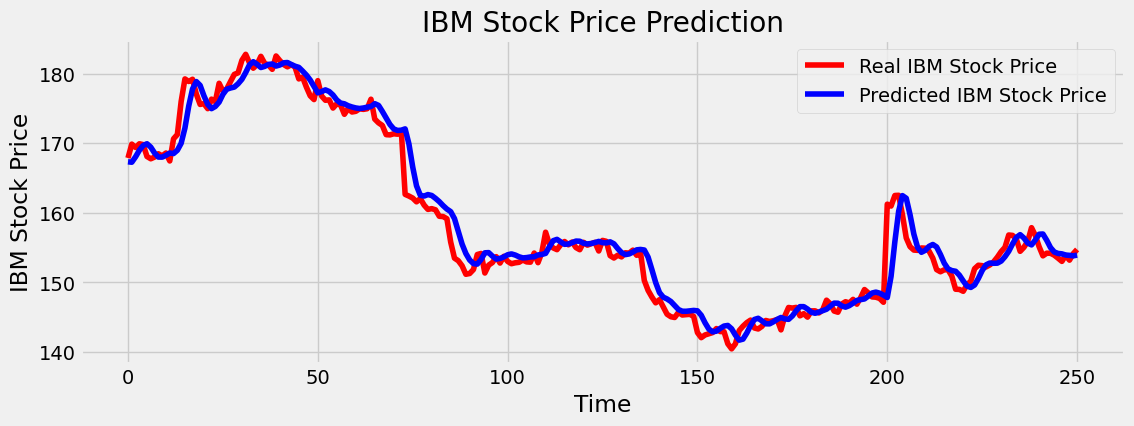

In [24]:
# Visualizing the results for LSTM
plot_predictions(test_set, predicted_stock_price)